In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import flopy
from modflowapi import ModflowApi

### Model name and workspace

In [2]:
folder_name = "mf6_model"
gwf_name = 'gwf'
gwe_name = 'gwe'
ws = os.path.join(".", folder_name)

In [3]:
if sys.platform == "win32":
    mf6_dll = "libmf6.dll"
else:
    mf6_dll = "libmf6.so"

if sys.platform == "win32":
    exe_name = "mf6.exe"
else:
    exe_name = "mf6"

In [4]:
mf6_dll = os.path.join(".", "libmf6.dll")
init_ws = os.path.abspath(os.getcwd())
print(mf6_dll, os.path.isfile(mf6_dll), init_ws)

.\libmf6.dll True D:\ITC\PhD\SSM\MODFLOWAPI\ex8_extend_ex7_add_gwe


### Model parameters

_Spatial and Temporal Discretization_

In [5]:
nlay, nrow, ncol = 2, 1, 1
shape3d = (nlay, nrow, ncol)
shape2d = (nrow, ncol)
delr, delc = 1., 1
area = delr * delc
aquifer_thickness = 10.
dz = aquifer_thickness / nlay
#elevations = [2595] + np.arange(-dz, -(aquifer_thickness + dz), -dz).tolist()
elevations = [26.0, 26.0 - dz, 26.0 - 2*dz]
nper, pertime, nstp, tsmult = 10, 1, 48, 1

_Hydraulic Properties_

In [6]:
k, ss, sy = 0.1, 1.5e-5, 0.05

_Initial Conditions_

In [7]:
h0 = elevations[0] - 2.5

_Evapotranspiration Data_

### Build a one-dimensional model

_Simulation Object_

In [8]:
sim = flopy.mf6.MFSimulation(sim_name=folder_name, sim_ws=ws, verbosity_level=1, memory_print_option="all", exe_name = exe_name)
tdis = flopy.mf6.ModflowTdis(sim, filename=f"{gwf_name}.tdis", time_units="days", nper=nper, perioddata=((pertime, nstp, tsmult),)*nper,)


_Groundwater Flow Model_

In [9]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwf_name, newtonoptions="NEWTON UNDER_RELAXATION", save_flows=True)
ims_gwf = flopy.mf6.ModflowIms(sim,  print_option="summary", complexity="MODERATE", filename=f"{gwf_name}.ims",
                               outer_maximum= 500, under_relaxation="dbd",
                               linear_acceleration="bicgstab", rcloserecord=[1e-6, "strict"],inner_dvclose=1e-8,outer_dvclose=1e-9,);
sim.register_ims_package(ims_gwf, [gwf.name])  

In [10]:
dis_gwf = flopy.mf6.ModflowGwfdis(gwf, length_units="meters", nlay=nlay, nrow=nrow, ncol=ncol, 
                        delr=delr, delc=delc, top=elevations[0], botm=elevations[1:])
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k)
sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, ss=ss, sy=sy)
ic = flopy.mf6.ModflowGwfic(gwf, strt=h0)
#api = flopy.mf6.ModflowGwfapi(gwf, pname="bmi-et", maxbound=1,)
rch = flopy.mf6.ModflowGwfrch(gwf, pname="rch_0", maxbound=10, save_flows=True, stress_period_data = [((0, 0, 0), 0.0001, 0)], auxiliary=["TEMPERATURE"])
#oc = flopy.mf6.ModflowGwfoc(gwf, printrecord={0: [("BUDGET", "ALL")]})
oc_gwf = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord = '{}.cbc'.format(gwf_name), 
                            budgetcsv_filerecord = '{}.cbc.csv'.format(gwf_name),
                            head_filerecord = '{}.hds'.format(gwf_name),
                            saverecord = [('HEAD', 'ALL'),('BUDGET', 'LAST')],
                            printrecord = [('HEAD', 'ALL'),('BUDGET', 'LAST')])
obs_lst = []
for k in range(nlay):
    obs_lst.append(["H{:02d}".format(k+1), "HEAD", (k, 0, 0)])
obs_gwf = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous={"gwhead.csv": obs_lst});

_Groundwater Heat Model_

In [11]:
gwe = flopy.mf6.ModflowGwe(sim, modelname=gwe_name, save_flows=True)
ims_gwe = flopy.mf6.ModflowIms(sim,  print_option="summary", filename=f"{gwe_name}.ims", complexity="SIMPLE",
                           linear_acceleration="bicgstab", rcloserecord=[1e-6, "strict"],inner_dvclose=1e-8,outer_dvclose=1e-9,);
sim.register_ims_package(ims_gwe, [gwe.name])

In [12]:
strt_temp = 10.0  # Initial temperature ($^{\circ}C$)
scheme = "Upstream"  # Advection scheme ($-$)
alh = 0.0  # No mechanical dispersion ($m^2/day$)
ath1 = 0.0  # No transverse dispersivity ($m^2/day$)
dispersivity = 0.0  # Longitudinal mechanical dispersion term ($m$)
porosity = 0.2  # Porosity ($-$)
rhos = 1500.0  # Density of dry solid aquifer material ($\frac{kg}{m^3}$)
cps = 760.0  # Heat capacity of dry solid aquifer material ($\frac{J}{kg \cdot ^{\circ} C}$)
rhow = 1000.0  # Density of water ($\frac{kg}{m^3}$)
cpw = 4183.0  # Heat capacity of water ($\frac{J}{kg \cdot ^{\circ} C}$)
lhv = 2500.0  # Latent heat of vaporization
ktw = 0.5918  # Thermal conductivity of water ($\frac{W}{m \cdot ^{\circ} C}$)
kts = 0.27  # Thermal conductivity of solid aquifer material ($\frac{W}{m \cdot ^{\circ} C}$)

In [13]:
# Instantiating MODFLOW 6 transport discretization package
dis_gwe = flopy.mf6.ModflowGwedis(gwe, length_units="meters", nlay=nlay, nrow=nrow, ncol=ncol, 
                        delr=delr, delc=delc, top=elevations[0], botm=elevations[1:])
# Instantiating MODFLOW 6 transport initial concentrations
ic_gwe =  flopy.mf6.ModflowGweic(gwe, strt=strt_temp, pname="IC", filename=f"{gwe_name}.ic",)
# Instantiating MODFLOW 6 transport advection package
adv = flopy.mf6.ModflowGweadv(gwe, scheme=scheme, pname="ADV", filename="{}.adv".format(gwe_name))
# Instantiating MODFLOW 6 transport dispersion package
cnd = flopy.mf6.ModflowGwecnd(gwe, xt3d_off=False, alh=alh, ath1=ath1, ktw=ktw * 86400, 
                              kts=kts * 86400, pname="CND",filename=f"{gwe_name}.cnd",)
# Instantiating MODFLOW 6 transport mass storage package
est = flopy.mf6.ModflowGweest(gwe, save_flows=True, porosity=porosity, cps=cps, rhos=rhos,
                              packagedata=[cpw, rhow, lhv], pname="EST", filename=f"{gwe_name}.est",)
# Instantiating MODFLOW 6 source/sink mixing package
sourcerecarray = [ ("rch_0", "AUX", "TEMPERATURE") ]
ssm = flopy.mf6.ModflowGwessm(gwe, sources = sourcerecarray, filename = "{}.ssm".format(gwe_name))

oc_gwe = flopy.mf6.ModflowGweoc(gwe, budget_filerecord = '{}.cbc'.format(gwe_name), 
                            budgetcsv_filerecord = '{}.cbc.csv'.format(gwe_name),
                            temperature_filerecord="{}.ucn".format(gwe_name),
                            saverecord = [('TEMPERATURE', 'LAST'),('BUDGET', 'LAST')],
                            printrecord = [('TEMPERATURE', 'LAST'),('BUDGET', 'LAST')])
# The following lines are commented on for now because of an (bug) error (Observation type not found: TEMPERATURE)
'''
obsgwe_lst = []
for k in range(nlay):
    obsgwe_lst.append(["T{:02d}".format(k+1), "TEMPERATURE", (k, 0, 0)])
obs_gwe = flopy.mf6.ModflowUtlobs(gwe, print_input=False, continuous={"gwtemp.csv": obsgwe_lst});
'''

'\nobsgwe_lst = []\nfor k in range(nlay):\n    obsgwe_lst.append(["T{:02d}".format(k+1), "TEMPERATURE", (k, 0, 0)])\nobs_gwe = flopy.mf6.ModflowUtlobs(gwe, print_input=False, continuous={"gwtemp.csv": obsgwe_lst});\n'

In [14]:
gwfgwe = flopy.mf6.ModflowGwfgwe(sim, exgtype='GWF6-GWE6', exgmnamea = gwf_name, exgmnameb = gwe_name, filename = 'gwf_gwe.gwfgwe')

_Write the Model Files_

In [15]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package gwf_gwe.gwfgwe...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package rch_0...
    writing package oc...
    writing package obs_0...
  writing model gwe...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package cnd...
    writing package est...
    writing package ssm...
    writing package oc...


_Retrieve a few processed items from the GWF model_

In [16]:
gwf_top = gwf.dis.top.array
gwf_botm = gwf.dis.botm.array
print(gwf_top.shape, gwf_botm.shape)
print(gwf_top, gwf_botm[-1])

(1, 1) (2, 1, 1)
[[26.]] [[16.]]


In [17]:
# forward model run
#success, buff = sim.run_simulation()

In [18]:

verbose, success = False, False

mf6_config_file = os.path.join(ws, 'mfsim.nam')
mf6 = ModflowApi(mf6_dll, working_directory=ws)

# initialize the model
mf6.initialize(mf6_config_file)

# time loop
current_time = mf6.get_current_time()
end_time = mf6.get_end_time()

# get pointer to simulated heads
head_tag = mf6.get_var_address("X", gwf_name.upper())
temp_tag = mf6.get_var_address("X", gwe_name.upper())

head = mf6.get_value_ptr(head_tag)
temp = mf6.get_value_ptr(temp_tag)

# maximum outer iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_1"))
max_iter


array([500])

In [19]:
head, temp

(array([23.5, 23.5]), array([10., 10.]))

In [20]:
# get pointers to API data
rch_address = mf6.get_var_address("RECHARGE", gwf_name.upper(), "RCH_0")
rch = mf6.get_value(rch_address)

In [21]:
# model time loop
kstp = 0
while current_time < end_time:
    # set values
    rch_updated = np.array([0.002])
    mf6.set_value(rch_address, rch_updated)
    # get values
    head = mf6.get_value_ptr(head_tag)[0]
    temp = mf6.get_value_ptr(temp_tag)[0]

    #print('Updating Time step: ' + str(kstp + 1))
    print('Updating Time step:  ' + str(kstp + 1) + '    Head = ' + str(round(head, 2)) + '   Temp = ' + str(round(temp, 2)))
    kstp = kstp + 1
    # Update models
    mf6.update() 
    current_time = mf6.get_current_time()

Updating Time step:  1    Head = 23.5   Temp = 10.0
Updating Time step:  2    Head = 23.5   Temp = 10.0
Updating Time step:  3    Head = 23.5   Temp = 10.0
Updating Time step:  4    Head = 23.5   Temp = 10.0
Updating Time step:  5    Head = 23.5   Temp = 10.0
Updating Time step:  6    Head = 23.5   Temp = 10.0
Updating Time step:  7    Head = 23.5   Temp = 10.0
Updating Time step:  8    Head = 23.51   Temp = 10.0
Updating Time step:  9    Head = 23.51   Temp = 10.0
Updating Time step:  10    Head = 23.51   Temp = 10.0
Updating Time step:  11    Head = 23.51   Temp = 10.0
Updating Time step:  12    Head = 23.51   Temp = 10.0
Updating Time step:  13    Head = 23.51   Temp = 10.0
Updating Time step:  14    Head = 23.51   Temp = 10.0
Updating Time step:  15    Head = 23.51   Temp = 10.0
Updating Time step:  16    Head = 23.51   Temp = 10.0
Updating Time step:  17    Head = 23.51   Temp = 10.0
Updating Time step:  18    Head = 23.51   Temp = 10.0
Updating Time step:  19    Head = 23.51   Te

In [22]:
''' 
# model time loop
kstp = 0
while current_time < end_time:
    # get dt and prepare for non-linear iterations
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)

    # convergence loop
    kiter = 0
    mf6.prepare_solve()

    while kiter < max_iter:
        if verbose:
            print(kiter, nodelist)
        # solve with updated well rate
        has_converged = mf6.solve(1)
        kiter += 1
        if has_converged:
            if verbose:
                break

    # finalize time step
    mf6.finalize_solve()

    # set values
    rch_updated = np.array([0.002])
    mf6.set_value(rch_address, rch_updated)
    # get values
    head = mf6.get_value_ptr(head_tag)[0]
    temp = mf6.get_value_ptr(temp_tag)[0]

    # finalize time step and update time
    mf6.finalize_time_step()
    current_time = mf6.get_current_time()
    
    #print('Updating Time step: ' + str(kstp + 1))
    #print('Updating Time step: ' + str(kstp + 1) + '   Head = ' + str(round(head, 2)) + ', and Temp = ' + str(round(temp, 2)))
    #kstp = kstp + 1
    
    # terminate if model did not converge
    if not has_converged:
        print("model did not converge")
        break
 '''        

' \n# model time loop\nkstp = 0\nwhile current_time < end_time:\n    # get dt and prepare for non-linear iterations\n    dt = mf6.get_time_step()\n    mf6.prepare_time_step(dt)\n\n    # convergence loop\n    kiter = 0\n    mf6.prepare_solve()\n\n    while kiter < max_iter:\n        if verbose:\n            print(kiter, nodelist)\n        # solve with updated well rate\n        has_converged = mf6.solve(1)\n        kiter += 1\n        if has_converged:\n            if verbose:\n                break\n\n    # finalize time step\n    mf6.finalize_solve()\n\n    # set values\n    rch_updated = np.array([0.002])\n    mf6.set_value(rch_address, rch_updated)\n    # get values\n    head = mf6.get_value_ptr(head_tag)[0]\n    temp = mf6.get_value_ptr(temp_tag)[0]\n\n    # finalize time step and update time\n    mf6.finalize_time_step()\n    current_time = mf6.get_current_time()\n    \n    #print(\'Updating Time step: \' + str(kstp + 1))\n    #print(\'Updating Time step: \' + str(kstp + 1) + \'  

In [23]:
# cleanup
try:
    mf6.finalize()
    success = True
except:
    raise RuntimeError

In [24]:
# Export heads and flows
headfile = '{}.hds'.format(gwf_name)
hds = flopy.utils.binaryfile.HeadFile(os.path.join(ws, headfile))
gwheads = gwf.output.head().get_data()

tempfile = '{}.ucn'.format(gwe_name)
#tmp = flopy.utils.binaryfile.UcnFile(os.path.join(ws, tempfile))
#gwtemps = gwe.output.temperature().get_data()

In [25]:
sim_heads = pd.read_csv(os.path.join(ws, "gwhead.csv"))
sim_heads


,time,H01,H02
0,0.020833,23.500042,23.500035
1,0.041667,23.500873,23.500745
2,0.062500,23.501705,23.501558
3,0.083333,23.502536,23.502387
4,0.104167,23.503368,23.503218
...,...,...,...
475,9.916667,23.894963,23.894813
476,9.937500,23.895794,23.895645
477,9.958333,23.896626,23.896476
478,9.979167,23.897457,23.897307


<Axes: xlabel='time'>

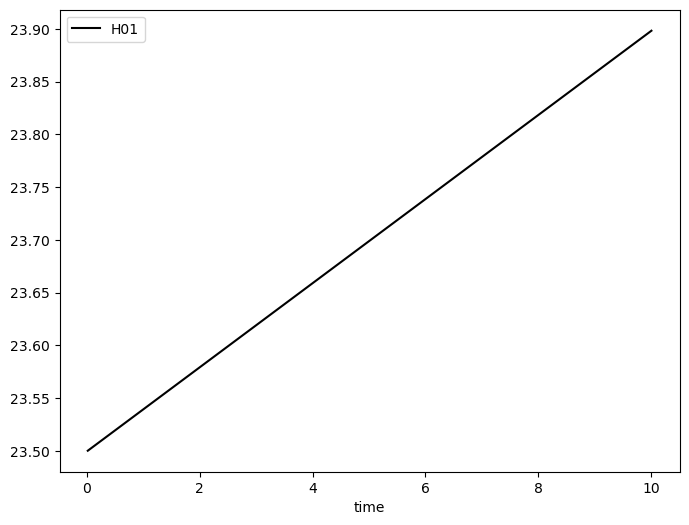

In [26]:
# Let's have a look at the time series of the simulated heads and observed heads at the observation location
fig, ax = plt.subplots(figsize = (8, 6))
sim_heads.plot(ax = ax, x = 'time', y = 'H01', kind = 'line', color = 'black', rot = 0, zorder = 1, fontsize = 10)